# 📊 Proyecto: Análisis y visualización de la calidad del aire: una exploración de contaminantes atmosféricos y su relación con el PM2.5
**Curso:** Samsung Innovation Campus – Módulo de Python (Ecuador 2025)  
**Seccion:** EC03  

---

## 🧩 Módulo: Adquisición de Datos

En esta sección se carga el dataset, se explora su estructura general y se validan los rangos de los contaminantes, utilizando las funciones del módulo `data_acquisition.py`.

El dataset contiene mediciones de diferentes gases y partículas contaminantes en el aire, registradas con fecha y hora.


### 📘 Descripción general de las columnas del dataset

| Columna | Descripción | Relevancia |
|----------|--------------|-------------|
| 📅 **Date** | Fecha y hora del registro | Permite analizar variaciones temporales. |
| 🏭 **CO** | Monóxido de carbono (ppm) | Gas tóxico, indicador de combustión incompleta. |
| 🚗 **NO** | Óxido nítrico | Se genera en la quema de combustibles fósiles. |
| 🚙 **NO2** | Dióxido de nitrógeno | Contaminante urbano, precursor del ozono. |
| 🌫️ **O3** | Ozono troposférico | Se forma con NOx + luz solar; irritante respiratorio. |
| 🌋 **SO2** | Dióxido de azufre | Proviene de la quema de carbón y petróleo. |
| ☁️ **PM2.5** | Partículas finas < 2.5 μm | Altamente dañinas, ingresan a los pulmones. |
| 🌧️ **PM10** | Partículas < 10 μm | Menos dañinas, quedan en vías respiratorias. |
| 🍃 **NH3** | Amoníaco | De origen agrícola, contribuye a partículas secundarias. |


In [49]:
# ===== Importar librerías principales ====
import warnings
import importlib
import src.data_acquisition as da
import src.data_processing as dp
import src.data_visualization as dv

# Recargar los módulos para reflejar cambios recientes
importlib.reload(dp) 
importlib.reload(da)
importlib.reload(dv)

warnings.filterwarnings('ignore')

In [50]:
# === Listar los archivos disponibles en la carpeta de datos ===
print("="*60)
print("📂 Archivos disponibles en la carpeta")
print("="*60)
for file in da.list_data_files("data"):
    print(f"- {file}")

📂 Archivos disponibles en la carpeta
- data\delhiaqi.csv


In [51]:
# Cargar de los datos del archivo CSV en un DataFrame
df_air_quality = da.load_data_csv('data/delhiaqi.csv')

✅ Archivo 'data/delhiaqi.csv' cargado exitosamente.


In [52]:
print("=" * 60)
print("📊 Exploración inicial de los datos")
print("=" * 60)

# Mostrar filas del DataFrame
da.preview_data(df_air_quality, num_rows=5)

📊 Exploración inicial de los datos

🔍 Primeras 5 filas del DataFrame:


,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19


In [53]:
# Mostrar dimensiones del DataFrame
da.get_dataframe_shape(df_air_quality)


📐 Dimensiones del DataFrame: 561 filas y 9 columnas


In [54]:
# Mostrar información detallada del DataFrame
da.get_dataframe_info(df_air_quality)


🧱 Columnas del Dataframe:
['date', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

📊 Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    561 non-null    object 
 1   co      561 non-null    float64
 2   no      561 non-null    float64
 3   no2     561 non-null    float64
 4   o3      561 non-null    float64
 5   so2     561 non-null    float64
 6   pm2_5   561 non-null    float64
 7   pm10    561 non-null    float64
 8   nh3     561 non-null    float64
dtypes: float64(8), object(1)
memory usage: 39.6+ KB


In [55]:
# Mostrar los valores faltantes por columna
da.get_missing_values(df_air_quality)


❗ Valores faltantes por columna:
date     0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64


## 🧩 Módulo: Procesamiento y limpieza de datos
En esta sección se prepara el conjunto de datos para el análisis, utilizando las funciones del módulo `data_processing.py`.
Se aplican los siguientes pasos:

1. Conversión de fechas al formato `datetime`.  
2. Eliminación de duplicados y valores negativos.  
3. Creación de columnas temporales (año, mes, día, hora).  
4. Cálculo automático del **Índice de Calidad del Aire (ICA)** basado en PM2.5.
5. Clasificación automática de cada registro en su categoría correspondiente según su valor de PM2.5.

### 🔹 Índice de Calidad del Aire (ICA)
El ICA mide la calidad del aire en una escala de **0 a >500**, dividiéndose en seis categorías de peligrosidad.  
A mayor índice, peor es la calidad del aire.  

| Categoría | Color | Rango ICA |
|-----------|-------|-----------|
| Buena | 🟢 Verde | 0 – 50 |
| Moderada | 🟡 Amarillo | 51 – 100 |
| Dañina para grupos sensibles | 🟠 Naranja | 101 – 150 |
| Dañina | 🔴 Rojo | 151 – 200 |
| Muy dañina | 🟣 Morado | 201 – 300 |
| Peligrosa | 🟤 Marrón | >300 |


In [56]:
# Limpiar y preparar los datos
df_clean = dp.clean_dataframe(df_air_quality)

# Agregar columna de categorías ICA (Índice de Calidad del Aire)
df_clean = dp.add_ica_category(df_clean)

# Mostrar las primera filas procesadas
da.preview_data(df_clean, num_rows=5)

✅ Datos limpios y listos para el análisis.

🔍 Primeras 5 filas del DataFrame:


,co,no,no2,o3,so2,pm2_5,pm10,nh3,year,month,day,hour,ica_category
date,,,,,,,,,,,,,
2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83,2023,1,1,0,Dañina
2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66,2023,1,1,1,Dañina
2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40,2023,1,1,2,Muy dañina
2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55,2023,1,1,3,Muy dañina
2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19,2023,1,1,4,Muy dañina


In [57]:
# Reporte de calidad de datos
reporte = dp.quality_report(df_clean)

print("📋 Reporte de Calidad de Datos:")
for key, value in reporte.items():
    print(f"{key}: {value}")

📋 Reporte de Calidad de Datos:
rows: 561
cols: 13
duplicates: 0
inferred_freq: h
missing: {'co': 0, 'no': 0, 'no2': 0, 'o3': 0, 'so2': 0, 'pm2_5': 0, 'pm10': 0, 'nh3': 0, 'year': 0, 'month': 0, 'day': 0, 'hour': 0, 'ica_category': 0}


In [58]:
# Estadísticas descriptivas
desc = dp.descriptives(df_clean)
print("📊 Estadísticas descriptivas por contaminante:")
display(desc)

📊 Estadísticas descriptivas por contaminante:


,count,mean,std,min,p05,p50,p95,max
co,561.0,3814.942210,3227.744681,654.22,1188.28,2590.18,11428.83,16876.22
no,561.0,51.181979,83.904476,0.00,0.00,13.30,236.03,425.58
no2,561.0,75.292496,42.473791,13.37,26.39,63.75,159.03,263.21
o3,561.0,30.141943,39.979405,0.00,0.00,11.80,124.45,164.51
so2,561.0,64.655936,61.073080,5.25,17.64,47.21,177.38,511.17
pm2_5,561.0,358.256364,227.359117,60.10,128.92,301.17,844.98,1310.20
pm10,561.0,420.988414,271.287026,69.08,158.34,340.90,1035.78,1499.27
nh3,561.0,26.425062,36.563094,0.63,4.31,14.82,102.34,267.51


In [59]:
# Promedios y resúmenes por mes

# Crear instancia de análisis
estacion = dp.EstacionCalidadAire("Delhi", df_clean)

# Promedio mensual de PM2.5
prom_mes_pm25 = estacion.promedio_por_mes("pm2_5")
print("📈 Promedio mensual de PM2.5:")
prom_mes_pm25.head()

📈 Promedio mensual de PM2.5:


,month,pm2_5
0,1,358.256364


In [60]:
# Obtener el máximo global de PM2.5
maximo_mensual_pm25 = estacion.maximo_global("pm2_5")
print(f"🔝 Máximo global de PM2.5: {maximo_mensual_pm25}")

🔝 Máximo global de PM2.5: 1310.2


In [61]:
# Días más contaminados
dias_peores = estacion.top_n_dias_mas_contaminados("pm2_5", n=10)
print("🚨 Días más contaminados por PM2.5:")
display(dias_peores)

🚨 Días más contaminados por PM2.5:


,date,pm2_5
0,2023-01-02,698.104167
1,2023-01-13,590.368333
2,2023-01-09,557.806250
3,2023-01-19,526.485833
4,2023-01-11,450.968750
5,2023-01-01,443.940000
6,2023-01-05,423.604583
7,2023-01-06,418.079583
8,2023-01-23,409.547083
9,2023-01-03,381.810417


In [62]:
# Contar registros por categoría ICA (Índice de Calidad del Aire)
print("📊 Distribución de categorías ICA:")
display(df_clean["ica_category"].value_counts())

📊 Distribución de categorías ICA:


ica_category
Peligrosa                       282
Muy dañina                      141
Dañina                           81
Dañina para grupos sensibles     48
Moderada                          9
Name: count, dtype: int64

# 🧩 Módulo: Visualización de Datos
En esta sección se generan distintos tipos de gráficos que permiten **interpretar y analizar la calidad del aire**, visualizando tendencias, correlaciones y distribuciones.
Se utilizan las funciones del módulo `data_visualization.py`.


## 📈 1. Evolución temporal de contaminantes
Visualiza la evolución de los **contaminantes** más relevantes a lo largo del tiempo.


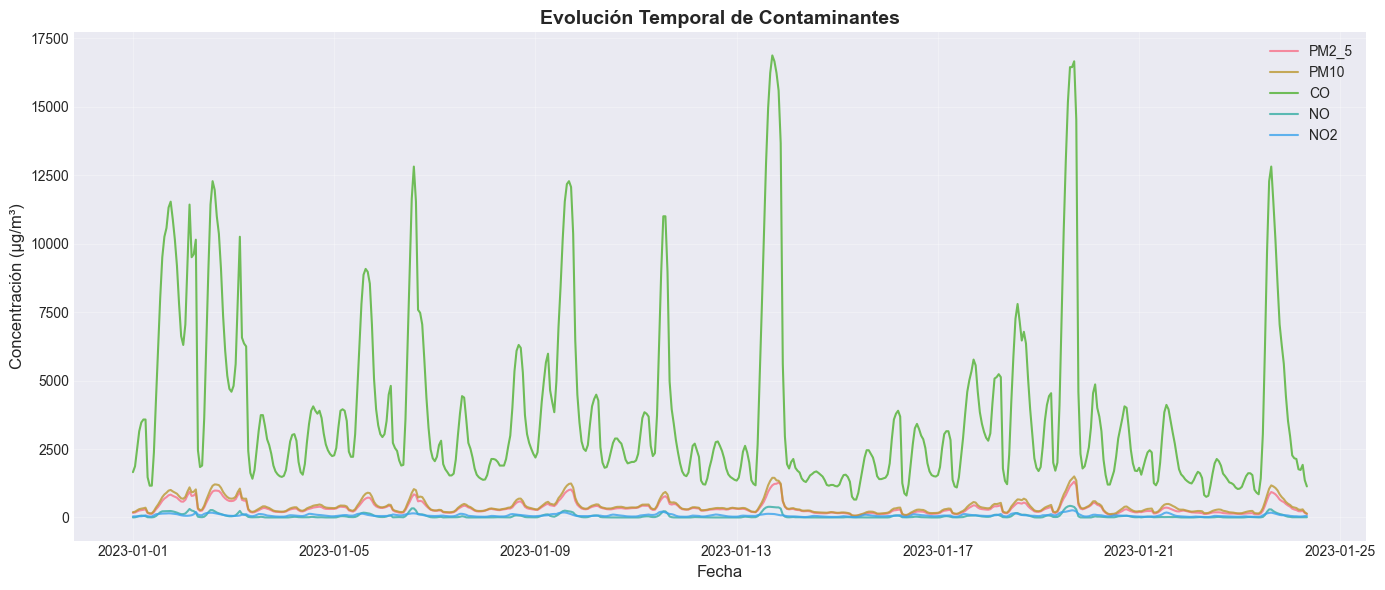

In [63]:
dv.plot_time_series(df_clean, columnas=['pm2_5', 'pm10', 'co', 'no', 'no2'])

#### Interpretacion de grafica:
Lectura: PM2.5/PM10 marcan picos definidos; gases (NO, NO2, CO) aumentan en horas pico.

Salud: picos indican alto riesgo respiratorio para sensibles.

Conclusión: viendo la gráfica podemos establecer medidas en los días y horas de pico (restricción de tráfico, alertas y recomendación de mascarilla a grupos sensibles)..

## 🌈 2. Distribución del Índice de Calidad del Aire (ICA)
Analiza la frecuencia y proporción de las categorías ICA en el dataset.


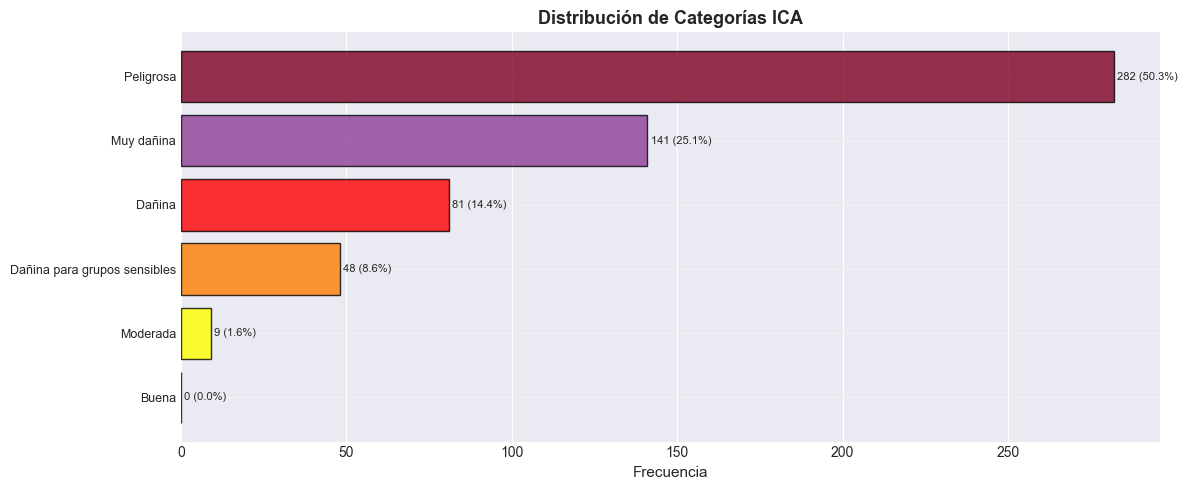

In [64]:
dv.plot_ica_distribution(df_clean)

#### Interpretacion de grafica:
Lectura: proporción de tiempo en cada categoría (verde→morado).

Salud: si crecen “Muy dañina/Peligrosa”, la población se expone frecuentemente a niveles nocivos.

Conclusión: podemos priorizar campañas y planes de contingencia en temporadas con mayor fracción en categorías altas.

## 🔥 3. Mapa de calor horario
Muestra los patrones promedio por **día de la semana** y **hora del día** para un contaminante específico (PM2.5).


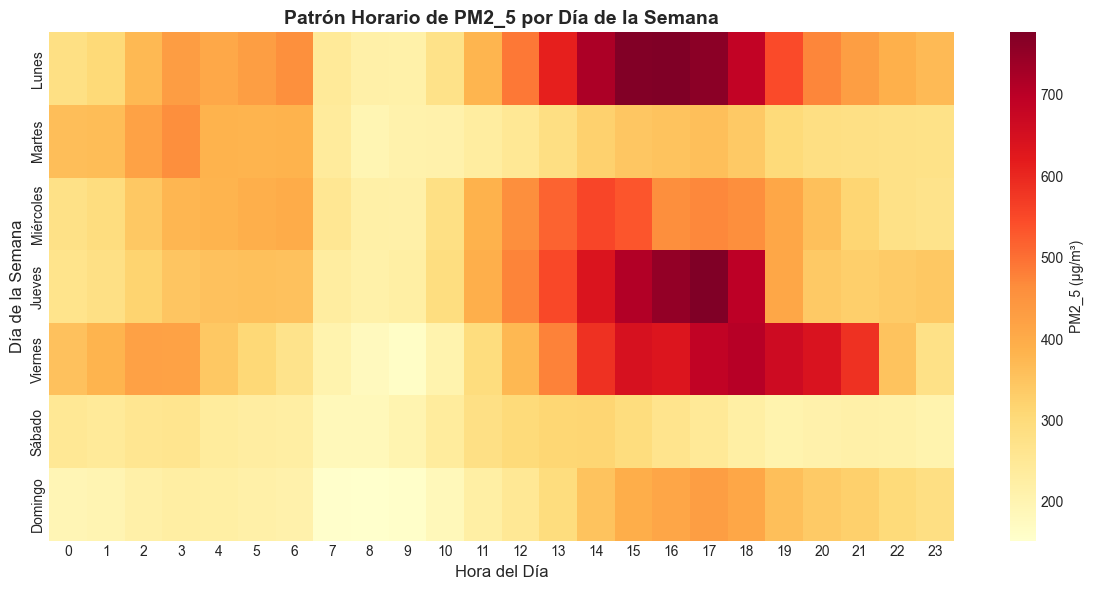

In [65]:
dv.plot_heatmap_hourly(df_clean, columna='pm2_5')

#### Interpretacion de grafica:
Lectura: concentraciones elevadas se concentran en horas pico laborales.

Salud: riesgo sistemático en franjas horarias previsibles.

Conclusión: podemos establecer medidas en las horas críticas (gestión del tránsito, escalonar horarios, controles a fuentes).

## 🧱 4. Matriz de correlación
Permite analizar la relación estadística entre los diferentes contaminantes del aire.


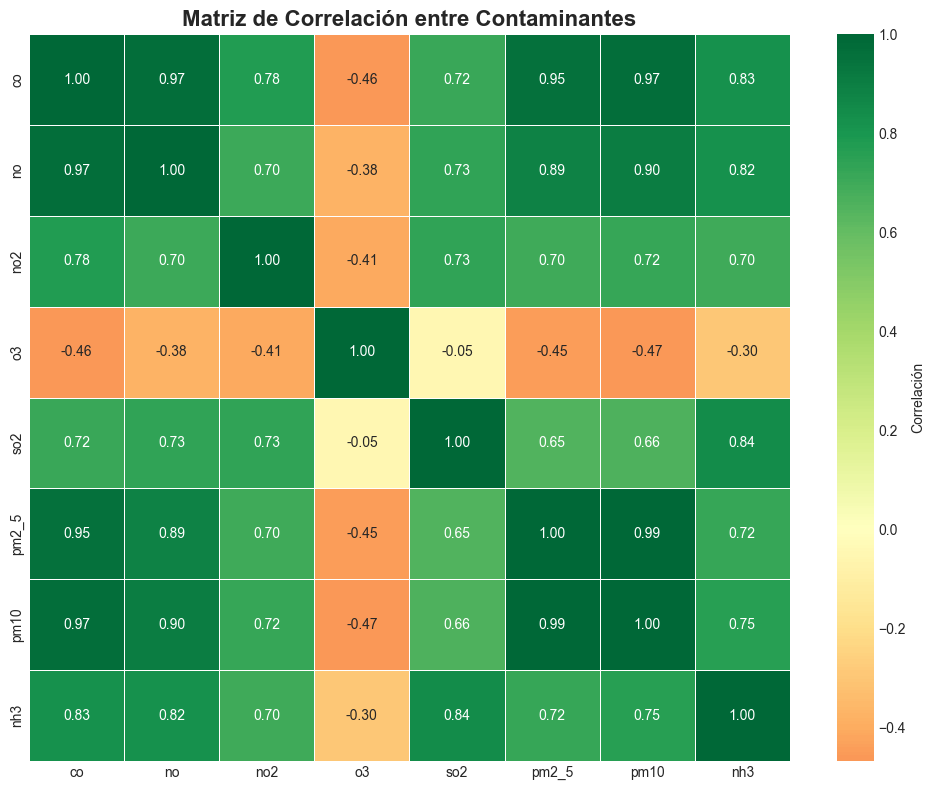

🔎 Correlaciones más altas con PM2.5:
 - pm10: 0.99
 - co: 0.95
 - no: 0.89
 - nh3: 0.72
 - no2: 0.70


,co,no,no2,o3,so2,pm2_5,pm10,nh3
co,1.000000,0.969740,0.776402,-0.463082,0.716831,0.953083,0.966801,0.826299
no,0.969740,1.000000,0.702201,-0.377813,0.734503,0.888810,0.903339,0.823638
no2,0.776402,0.702201,1.000000,-0.407177,0.734961,0.698696,0.720050,0.700254
o3,-0.463082,-0.377813,-0.407177,1.000000,-0.049158,-0.450458,-0.468477,-0.299663
so2,0.716831,0.734503,0.734961,-0.049158,1.000000,0.648996,0.658325,0.843635
pm2_5,0.953083,0.888810,0.698696,-0.450458,0.648996,1.000000,0.994088,0.720303
pm10,0.966801,0.903339,0.720050,-0.468477,0.658325,0.994088,1.000000,0.754468
nh3,0.826299,0.823638,0.700254,-0.299663,0.843635,0.720303,0.754468,1.000000


In [66]:
dv.plot_correlation_matrix(df_clean)

#### Interpretacion de grafica:

Lectura: PM2.5 correlaciona fuertemente con NO, NO2 y CO.

Salud: tráfico/combustión explican buena parte del riesgo.

Conclusión: podemos priorizar intervenciones sobre fuentes móviles y combustión para reducir la carga de PM2.5.

## 🚨 5. Top 10 días más contaminados
Identifica los **días con mayor concentración de PM2.5** en el periodo analizado.


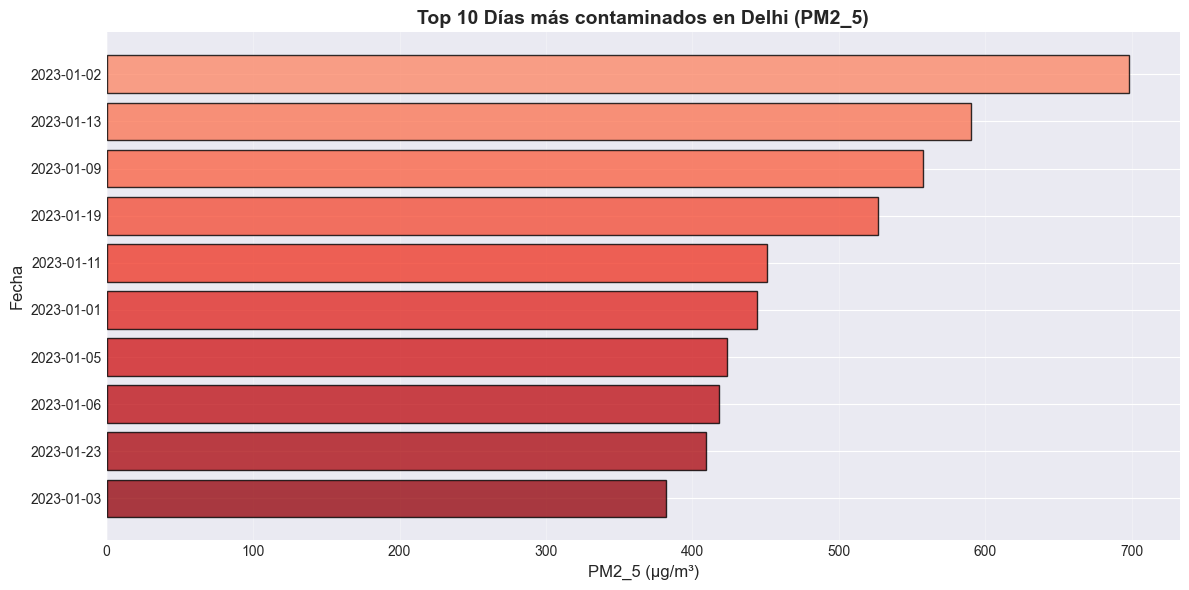

In [67]:
dv.plot_top_n_contaminated_days(estacion, columna='pm2_5', n=10)

#### Interpretacion de grafica:
Lectura: fechas específicas con PM2.5 extremo.

Salud: alta probabilidad de exacerbaciones asmáticas y eventos respiratorios.

Conclusión: podemos activar protocolos de alerta temprana y comunicación focalizada en esos días (evitar exteriores, teletrabajo, filtros).

## ⚖️ 7. Comparación de contaminantes con mayor correlación con el PM2.5
Analiza la relación entre ambos contaminantes mediante un diagrama de dispersión.


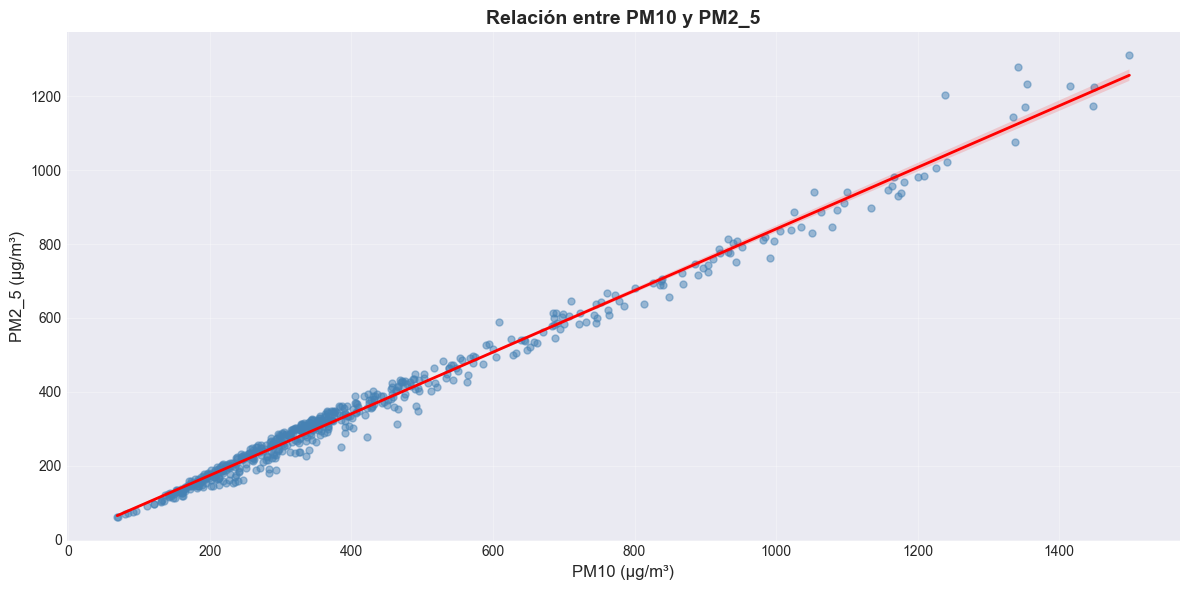

In [68]:
dv.plot_correlated_pollutants(df_clean, contaminante='pm10', objetivo='pm2_5')

#### Interpretacion de grafica:
Lectura: relación positiva consistente.

Salud: partículas gruesas y finas co-ocurren, aumentando irritación y penetración respiratoria.

Conclusión: podemos articular medidas duales (control de polvo + combustión) en episodios altos.

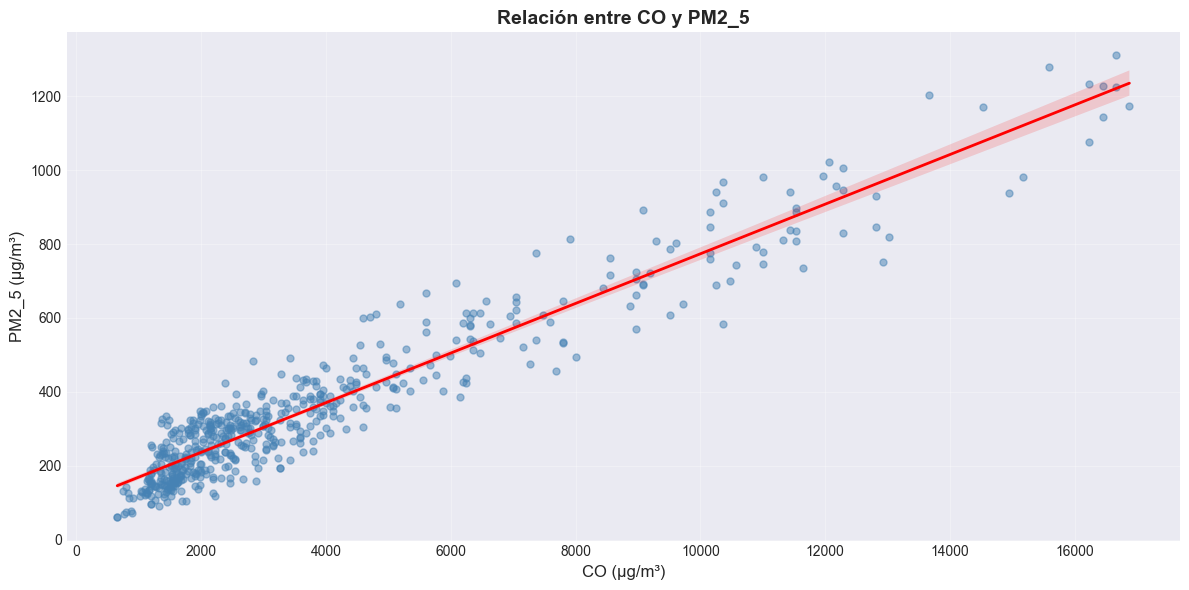

In [69]:
# Correlación de PM2.5 con 'co': 0.95
dv.plot_correlated_pollutants(df_clean, contaminante='co', objetivo='pm2_5')

#### Interpretacion de grafica:
Lectura: correlación alta sugiere influencia de combustión vehicular.

Salud: exposición vinculada a tránsito incrementa riesgo en vías principales.

Conclusión: podemos implementar zonas de bajas emisiones y fiscalización a flotas en ejes críticos.

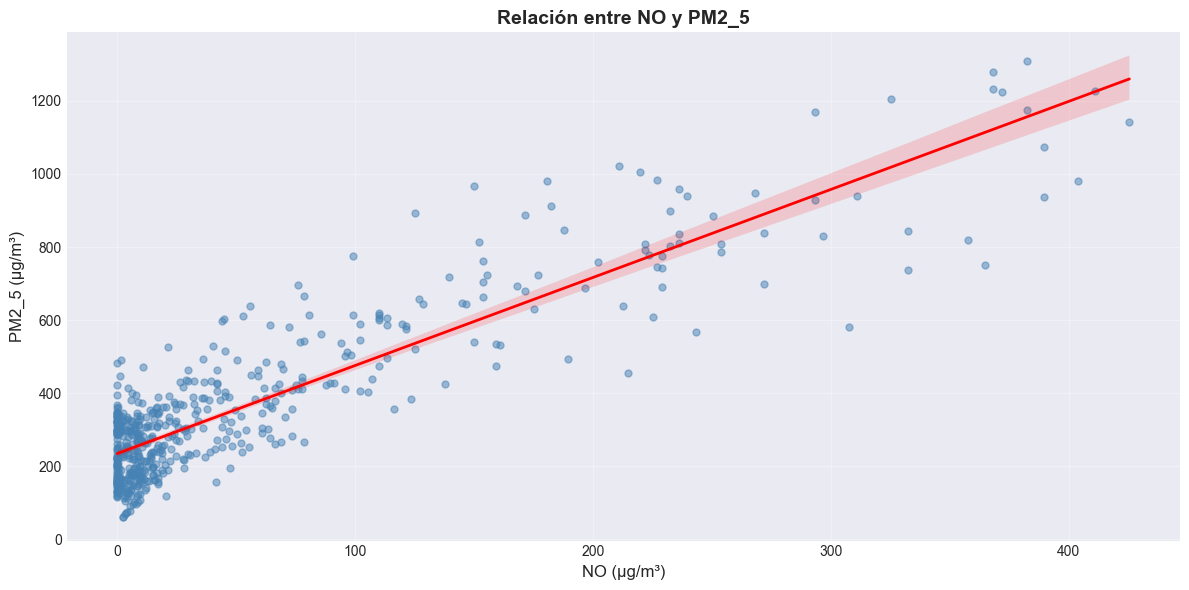

In [70]:
# Correlación de PM2.5 con 'no': 0.89
dv.plot_correlated_pollutants(df_clean, contaminante='no', objetivo='pm2_5')


#### Interpretacion de grafica:
Lectura: relación positiva, especialmente en horas pico.

Salud: agrava síntomas en población vulnerable.

Conclusión: podemos intensificar control de fuentes móviles en franjas pico y mejorar transporte público.

## 🧠 Módulo de Interpretación: Riesgo en salud basado en ICA y contaminantes

En esta sección traducimos resultados numéricos (niveles de contaminantes, correlaciones, ICA) en implicaciones para la salud, usando visualizaciones que comuniquen riesgo, tendencia y comparación.


### 🧩 1) Relacionar los valores del ICA con efectos en la salud

La siguiente tabla resume las categorías del ICA (basado en PM2.5) y su impacto en la salud. Más abajo, se muestra la distribución temporal por categoría en el dataset actual.


In [71]:
import pandas as pd
from IPython.display import display

# Definición de categorías de salud por PM2.5 (EPA)
ica_health_table = pd.DataFrame({
    'Categoría ICA': ['Buena', 'Moderada', 'Dañina para grupos sensibles', 'Muy dañina', 'Peligrosa'],
    'Rango PM2.5 (µg/m³)': ['0–12', '12.1–35.4', '35.5–55.4', '55.5–150.4', '>150.4'],
    'Impacto en la salud': [
        'Sin efectos visibles',
        'Leve irritación en personas sensibles',
        'Riesgo respiratorio leve',
        'Efectos respiratorios y cardíacos',
        'Riesgo alto para toda la población'
    ]
})
display(ica_health_table)

# Distribución de tiempo por categoría (usa columna 'ica_category' generada en dp.add_ica_category)
if 'ica_category' in df_clean.columns:
    categoria_counts = df_clean['ica_category'].value_counts(dropna=False).rename_axis('Categoría').reset_index(name='conteo')
    categoria_counts['porcentaje'] = (categoria_counts['conteo'] / categoria_counts['conteo'].sum()) * 100
    display(categoria_counts)
else:
    print(" No se encontró la columna 'ica_category'. Asegúrate de ejecutar la sección de procesamiento de datos.")


,Categoría ICA,Rango PM2.5 (µg/m³),Impacto en la salud
0,Buena,0–12,Sin efectos visibles
1,Moderada,12.1–35.4,Leve irritación en personas sensibles
2,Dañina para grupos sensibles,35.5–55.4,Riesgo respiratorio leve
3,Muy dañina,55.5–150.4,Efectos respiratorios y cardíacos
4,Peligrosa,>150.4,Riesgo alto para toda la población


,Categoría,conteo,porcentaje
0,Peligrosa,282,50.267380
1,Muy dañina,141,25.133690
2,Dañina,81,14.438503
3,Dañina para grupos sensibles,48,8.556150
4,Moderada,9,1.604278


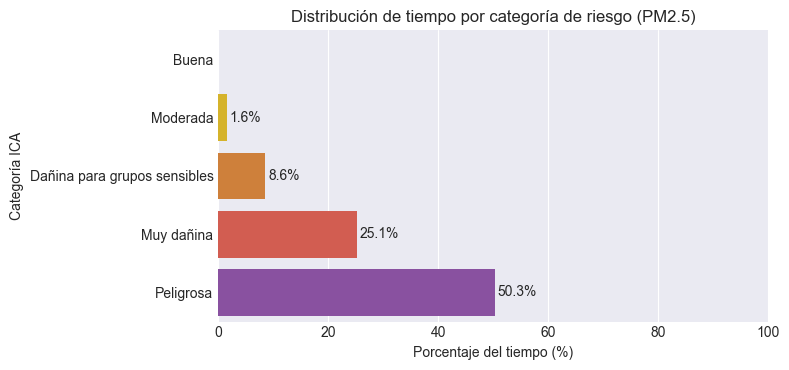

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'ica_category' in df_clean.columns:
	order = ['Buena', 'Moderada', 'Dañina para grupos sensibles', 'Muy dañina', 'Peligrosa']
	plot_df = categoria_counts.set_index('Categoría').reindex(order).reset_index()
	palette = {
		'Buena': '#2ECC71',
		'Moderada': '#F1C40F',
		'Dañina para grupos sensibles': '#E67E22',
		'Muy dañina': '#E74C3C',
		'Peligrosa': '#8E44AD'
	}
	plt.figure(figsize=(8, 3.8))
	sns.barplot(data=plot_df, y='Categoría', x='porcentaje', palette=palette)
	plt.xlabel('Porcentaje del tiempo (%)')
	plt.ylabel('Categoría ICA')
	plt.title('Distribución de tiempo por categoría de riesgo (PM2.5)')
	for i, v in enumerate(plot_df['porcentaje']):
		plt.text(v + 0.5, i, f"{v:.1f}%", va='center')
	plt.xlim(0, max(100, plot_df['porcentaje'].max() + 5))
	plt.tight_layout()
	plt.show()
else:
	print("⚠️ No se encontró la columna 'ica_category'.")


### 📈 2) Correlaciones entre contaminantes y riesgo en salud

A continuación se muestra un mapa de calor de correlaciones entre contaminantes. Valores cercanos a 1 indican relación fuerte; si están altamente correlacionados con PM2.5, pueden asociarse con mayor riesgo respiratorio.


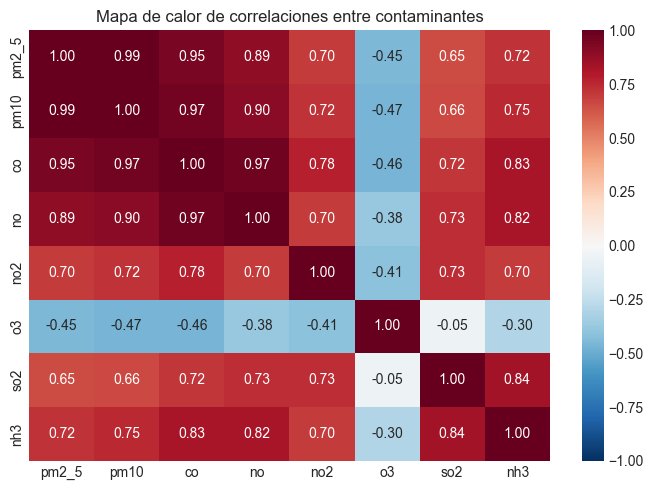

🔎 Correlaciones más altas con PM2.5:
 - pm10: 0.99
 - co: 0.95
 - no: 0.89
Interpretación: correlaciones altas sugieren factores asociados a mayor riesgo respiratorio, p. ej., tráfico (NO, NO2) o combustión (CO).


In [73]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cols = [c for c in ['pm2_5','pm10','co','no','no2','o3','so2','nh3'] if c in df_clean.columns]
if len(cols) >= 2:
	corr = df_clean[cols].corr(method='pearson')
	plt.figure(figsize=(7, 5))
	sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='RdBu_r', fmt='.2f')
	plt.title('Mapa de calor de correlaciones entre contaminantes')
	plt.tight_layout()
	plt.show()
	# Resumen centrado en PM2.5
	if 'pm2_5' in corr.columns:
		pm25_corr = corr['pm2_5'].drop('pm2_5', errors='ignore').sort_values(ascending=False)
		top = pm25_corr.head(3)
		print('🔎 Correlaciones más altas con PM2.5:')
		for k, v in top.items():
			print(f" - {k}: {v:.2f}")
		print("Interpretación: correlaciones altas sugieren factores asociados a mayor riesgo respiratorio, p. ej., tráfico (NO, NO2) o combustión (CO).")
else:
	print('⚠️ No hay suficientes columnas para calcular correlaciones.')


## 🧾 Conclusiones e implicaciones para la salud

- **Distribución por categorías ICA (PM2.5)**: La gráfica de barras muestra qué proporción del tiempo se concentra en cada categoría. Un mayor peso en categorías **amarillo/naranja/rojo/morado** implica **mayor exposición poblacional a riesgo respiratorio y cardiovascular**. Si la fracción en "Muy dañina" o "Peligrosa" es apreciable, se recomienda activar **alertas de salud** y medidas de mitigación (teletrabajo, restringir quemas, control de tránsito).

- **Correlaciones entre contaminantes**: Las correlaciones elevadas de **PM2.5** con **NO, NO₂ y CO** sugieren que las **fuentes móviles y de combustión** son determinantes del material particulado fino. Esto respalda intervenciones sobre **tráfico, combustibles y fuentes puntuales**. Una correlación positiva fuerte implica que **episodios de tráfico intenso coinciden con aire más dañino**.

- **Evolución temporal con categorías de riesgo**: Los picos coloreados en **rojo/morado** identifican **días y franjas horarias** de mayor riesgo para asmáticos y población sensible. Estos episodios deben comunicarse con **recomendaciones puntuales** (evitar ejercicio al aire libre, uso de mascarilla, priorizar interiores ventilados con filtración). La concentración de picos en ciertos **meses o horas** sugiere **patrones estacionales o diarios** que pueden guiar políticas (p. ej., gestión del tráfico en horas punta).

- **Factores meteorológicos**: Cuando la temperatura es alta y/o la humedad es baja, puede observarse una **tendencia al aumento de PM2.5** por **estancamiento y menor dispersión**; vientos débiles refuerzan el riesgo. Esto implica que, en **condiciones meteorológicas adversas**, deben **intensificarse las advertencias y controles**.

- **Dashboard de riesgo**: El indicador diario de PM2.5 y la **categoría ICA actual** permiten una **lectura rápida del nivel de riesgo** y entregan una **recomendación práctica** (desde normalidad hasta evitar exteriores y uso de mascarilla N95). Este panel es útil para **comunicación pública** y para **operación municipal** en tiempo casi real.

### Recomendaciones para la salud basandonos en la investigacion
- **Corto plazo**: Comunicación de riesgo en días críticos, promoción del **uso de mascarilla** y **reducción de actividad física** en exteriores para grupos sensibles.
- **Mediano plazo**: **Gestión del tráfico** (zonas de bajas emisiones, control de diésel), programas de **transporte público** y **movilidad activa**.
- **Monitoreo**: Mantener y ampliar mediciones; incorporar **variables meteorológicas** y **origen de fuentes** para mejorar predicción y prevención de episodios.

